In [1]:
import gym
import roboschool
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
plt.style.use('seaborn-white')
from baselines.common import set_global_seeds, tf_util as U
from baselines import bench
import gym, logging
import roboschool
from baselines import logger
from baselines.ppo1 import mlp_policy, pposgd_simple
from base_line_model.mlp import MlpPolicy_new
from base_line_model.PPO_agent import learning_agent

In [2]:
env = gym.make("RoboschoolWalker2d-v1")
env.seed(0)
np.random.seed(0)

seed = 1
logger.configure()
U.make_session(num_cpu=16).__enter__()
set_global_seeds(seed)

[2018-04-14 16:14:57,544] Making new env: RoboschoolWalker2d-v1


Logging to /tmp/openai-2018-04-14-16-14-57-550825


In [3]:
env2 = gym.make('RoboschoolWalker2d-v1')
env2 = bench.Monitor(env2, logger.get_dir(),allow_early_resets=True)
env2.seed(seed)
gym.logger.setLevel(logging.WARN)
class pargm(object):
    def __init__(self):
        self.timesteps_per_actorbatch = 25000#25000 # timesteps per actor per update
        self.clip_param = 0.2 
        self.entcoeff = 0.0 # clipping parameter epsilon, entropy coeff
        self.optim_epochs = 10 
        self.optim_stepsize = 3e-4
        self.optim_batchsize = 64# optimization hypers
        self.gamma = 0.99
        self.lam = 0.95 # advantage estimation
        self.max_timesteps=10e8#1e10 
        self.max_episodes=0 
        self.max_iters=0 
        self.max_seconds=0  # time constraint
        self.callback=None # you can do anything in the callback, since it takes locals(), globals()
        self.adam_epsilon=1e-5
        self.schedule='linear' # annealing for stepsize parameters (epsilon and adam)


def policy_fn(name, ob_space, ac_space):
        return MlpPolicy_new(name=name, ob_space=ob_space, ac_space=ac_space,
            hid_size=64, num_hid_layers=2)
    
parg = pargm()
agent = learning_agent('pi2', env2, policy_fn, parg)
agent.restore('walker_mem')

[2018-04-14 16:14:57,586] Making new env: RoboschoolWalker2d-v1


INFO:tensorflow:Restoring parameters from walker_mem/data


[2018-04-14 16:14:58,376] Restoring parameters from walker_mem/data


In [4]:
repeat_times = 1000
observation_history = []
score_list = []
r2_list = []
for _ in range(repeat_times):
        observation = env.reset()
        done = False
        count_epi = 0
        score = 0
        s2 = 0
        while done == False:
            action = agent.action_ev(observation) # collect traj and agent current policy
            observation_, reward, done, info = env.step(action)
            observation = observation_
            r2 = reward
            observation_history.append(observation)
            score = score + reward
            # number of step before exit the simulation
            count_epi = count_epi + 1
            s2 = s2 + r2
        score_list.append(score)
        r2_list.append(s2)

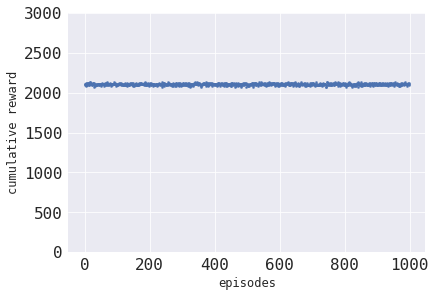

In [5]:
fon_size = 17
sns.set(context = "paper", font = "monospace", font_scale=2)
font_size = 12
x = list(range(0, 1000))
plt.scatter(x, score_list, s = 5)
plt.xlabel('episodes', fontsize = font_size)
plt.ylabel('cumulative reward',fontsize = font_size)
plt.ylim([0,3000])
plt.show()

# Sensor data statistics

In [6]:
sensor_array = np.array(observation_history)
sensor_array.shape

(1000000, 22)

In [7]:
np.mean(sensor_array, 0)

array([-0.31759298,  0.        ,  1.        ,  0.42172953,  0.        ,
        0.02065161,  0.        , -0.74775046,  0.39484787, -0.00464534,
        0.24083157, -0.00674927,  0.85244334,  0.00493959,  0.38521326,
       -0.00690156,  0.23350836, -0.00468008,  0.90126151,  0.00367392,
        0.59796101,  0.82420599], dtype=float32)

In [8]:
np.var(sensor_array, 0)

array([ 0.00338349,  0.        ,  0.        ,  1.03404284,  0.        ,
        1.01188457,  0.        ,  0.01528754,  0.13575062,  0.23478681,
        0.19928251,  0.23636317,  0.01878595,  0.03568238,  0.11593413,
        0.21493389,  0.04685972,  0.05619867,  0.02257879,  0.02064291,
        0.23985499,  0.14508484], dtype=float32)

In [9]:
np.std(sensor_array, 0)

array([ 0.05816781,  0.        ,  0.        ,  1.01687896,  0.        ,
        1.0059247 ,  0.        ,  0.12364278,  0.36844352,  0.48454803,
        0.44641069,  0.48617196,  0.13706185,  0.18889782,  0.340491  ,
        0.46360964,  0.21647106,  0.23706259,  0.15026239,  0.14367642,
        0.48974994,  0.38090006], dtype=float32)

In [10]:
np.mean(r2_list)

2107.0059636094843

In [11]:
np.var(r2_list)

132.67386013259284